<img src='https://github.com/Ikomia-dev/notebooks/blob/main/examples/img/banner_ikomia.png?raw=true'>

# How to train D-FINE

## Overview of D-FINE
Traditional real-time object detectors like YOLO do a great job balancing speed and accuracy, but they often struggle with pinpointing exact object locations because they rely on fixed-coordinate bounding boxes. 

[D-FINE](https://github.com/Peterande/D-FINE) takes a approach by treating bounding box regression as a fine-grained distribution refinement process. [1] This means instead of just predicting static coordinates, it refines object locations step by step, leading to more precise detections without sacrificing speed. The result? D-FINE outperforms many existing models in real-time settings, making it a solid choice for resource-limited environments like mobile devices and edge computing


### 🌆 Architecture and innovations:

Object detection algorithms typically use one of two main approaches:
1.	**Anchor-based detectors** (e.g., Faster R-CNN) that rely on predefined anchor boxes.
2.	**Anchor-free detectors** (e.g., DETR) that directly predict object locations and categories.
While DETR (Detection Transformer) models eliminate the need for anchors and non-maximum suppression (NMS), they suffer from high computational costs and suboptimal bounding box regression. D-FINE addresses these issues through:
    - **Fine-grained Distribution Refinement (FDR)**: Transforming bounding box regression into an iterative probability distribution refinement process.
    - **Global Optimal Localization Self-Distillation (GO-LSD)**: Enhancing localization precision by transferring knowledge from refined distributions to earlier layers.


## Setup

Please use a GPU for this tutorial.

In the menu, select "Runtime" then "Change runtime type", choose GPU in "Hardware accelerator".

Check your GPU with the following command:

In [ ]:
!nvidia-smi

First of all, you need to install Ikomia API pip package.

In [ ]:
!pip install ikomia



---


**-Google Colab ONLY- Restart runtime**

Click on the "RESTART RUNTIME" button at the end the previous window.





---

Ikomia API has already more than 300 pre-integrated algorithms but the most interesting algorithms are in [Ikomia HUB](https://github.com/Ikomia-hub).


## How to train D-FINE on a custom dataset

Download your dataset from your preferred tool. In this example, we use a dataset from **Roboflow** which is a great annotation platform used by many developers and companies. The dataset is exported in COCO format.

In [4]:
import requests
import zipfile
import os


# Download the file
url = "https://universe.roboflow.com/ds/2qbMqn1RdR?key=gkBuCirpus"
response = requests.get(url, stream=True)
with open("roboflow.zip", "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

# Unzip the file
with zipfile.ZipFile("roboflow.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Remove the zip file
os.remove("roboflow.zip")


In order to train D-FINE on your custom dataset, please create a new workflow from scratch.

Then you need 2 components:

1.   A COCO dataset loader which loads the dataset and convert it to an Ikomia format
2.   The D-FINE training algorithm which loads dataset in Ikomia format

Add these 2 previous algorithms to your workflow and then it will automagically download all algorithms from Ikomia Hub and install all the Python dependencies (the 1st time, it can take a while, be patient ! ).

Now, it's time to train your model !

In [2]:
from ikomia.dataprocess.workflow import Workflow
import os

#----------------------------- Step 1 -----------------------------------#
# Create a workflow which will take your dataset as input and
# train a D-FINE model on it
#------------------------------------------------------------------------#
wf = Workflow()

#----------------------------- Step 2 -----------------------------------#
# First you need to convert the COCO format to IKOMIA format.
# Add an Ikomia dataset converter to your workflow.
#------------------------------------------------------------------------#

dataset = wf.add_task(name="dataset_coco")

dataset.set_parameters({
    "json_file": os.getcwd()+"/train/_annotations.coco.json",
    "image_folder": os.getcwd()+"/train",
    "task":"detection",
    "output_folder": os.getcwd()+"/dataset"
})

#----------------------------- Step 3 -----------------------------------#
# Then, you want to train a D-FINE model.
# Add D-FINEtraining algorithm to your workflow
#------------------------------------------------------------------------#
train = wf.add_task(name="train_d_fine", auto_connect=True)

train.set_parameters({
    "model_name": "dfine_m",
    "epochs": "100",
    "batch_size": "8",
    "input_size": "640",
    "dataset_split_ratio": "0.8",
    "workers": "4",  # recommended to set to 0 if you are using Windows
    "weight_decay": "0.000125",
    "lr": "0.00055",
    "output_folder": os.getcwd(),
})

#----------------------------- Step 4 -----------------------------------#
# Execute your workflow.
# It automatically runs all your tasks sequentially.
#------------------------------------------------------------------------#
wf.run()

MLflow server is started at http://localhost:5000
Tensorboard server is started at http://localhost:6006
Checking dataset.yaml at: /home/jupyter/Ikomia/Plugins/Python/train_d_fine/dataset/dataset.yaml
Preparing COCO-style dataset...
Dataset successfully split and converted to COCO format.
Train images: 132, Valid images: 33
Train annotations saved to: /home/jupyter/Ikomia/Plugins/Python/train_d_fine/dataset/train/train_coco_annotation.json
Valid annotations saved to: /home/jupyter/Ikomia/Plugins/Python/train_d_fine/dataset/valid/valid_coco_annotation.json

Final dataset info: {'train_annot_file': '/home/jupyter/Ikomia/Plugins/Python/train_d_fine/dataset/train/train_coco_annotation.json', 'train_img_dir': '/home/jupyter/Ikomia/Plugins/Python/train_d_fine/dataset/train/images', 'val_annot_file': '/home/jupyter/Ikomia/Plugins/Python/train_d_fine/dataset/valid/valid_coco_annotation.json', 'val_img_dir': '/home/jupyter/Ikomia/Plugins/Python/train_d_fine/dataset/valid/images', 'nc': 2, 'name

## Infer D-FINE object detection on images

Once the training is finished, you may want to experiment the fresh model on new test images. Just use the following code to create a YOLO v8 instance
segmentation inference workflow.
Then run and test !

In [3]:
# Set the output folder name
TIMESTAMP = "dfine_m_20250205_104429"

In [7]:
import os
from ikomia.dataprocess.workflow import Workflow

# Create your workflow for D-FINE inference
wf = Workflow()

# Add D-FINEinstance segmentation to your workflow
d_fine = wf.add_task(name="infer_d_fine", auto_connect=True)
d_fine.set_parameters({
    "model_weight_file": os.getcwd()+ f'/{TIMESTAMP}/best_stg1.pth',
    "config_file": os.getcwd()+ f'/{TIMESTAMP}/config_{TIMESTAMP}.yaml',
    "class_file": os.getcwd()+ f'/{TIMESTAMP}/class_names.txt',
    "conf_thres": "0.5",
    "input_size":"640"
})

## Run and display your results

Workflow Untitled run successfully in 694.473037 ms.


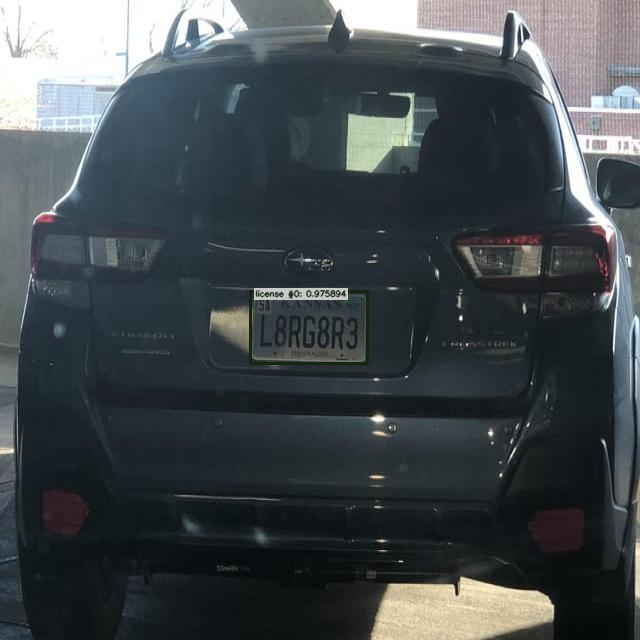

In [5]:
from ikomia.utils.displayIO import display
from PIL import ImageShow
ImageShow.register(ImageShow.IPythonViewer(), 0)

# Apply D-FINE object detection on your image
# By default, D-FINE runs with a pre-trained model based on COCO 
# To use your custom model, set the parameters in the previous cell
img_path = os.path.join(os.getcwd(),"test", "1k9uinoun9ha1_jpg.rf.ddaa941b04990f4a189d077ddbed134f.jpg")
wf.run_on(path=img_path)

# Get D-FINE image result
img_bbox = d_fine.get_image_with_graphics()

# Display in Colab
display(img_bbox)

## OCR - Text Recognition

Workflow Untitled run successfully in 6205.587091 ms.


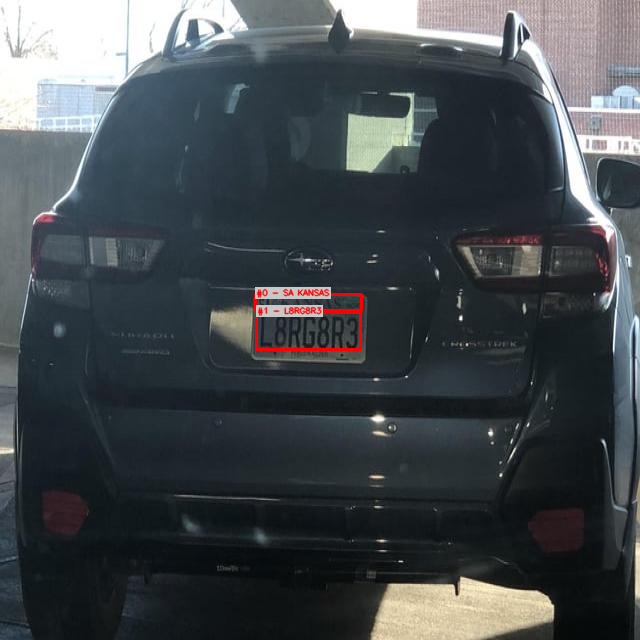

In [6]:
# Init your workflow
wf = Workflow()

# Add D-FINEinstance segmentation to your workflow
d_fine = wf.add_task(name="infer_d_fine", auto_connect=True)

d_fine.set_parameters({
    "model_weight_file": os.getcwd()+ f'/{TIMESTAMP}/best_stg1.pth',
    "config_file": os.getcwd()+ f'/{TIMESTAMP}/config_{TIMESTAMP}.yaml',
    "class_file": os.getcwd()+ f'/{TIMESTAMP}/class_names.txt',
    "conf_thres": "0.5",
    "input_size":"640"
})

# Add text recognition algorithm
text_rec = wf.add_task(name="infer_florence_2_ocr", auto_connect=True)

# Run the workflow on image
wf.run_on(path=os.getcwd()+"/test/1k9uinoun9ha1_jpg.rf.ddaa941b04990f4a189d077ddbed134f.jpg")

# Display results
img_output = text_rec.get_output(0)
recognition_output = text_rec.get_output(1)
display(img_output.get_image_with_mask_and_graphics(recognition_output))

## Run on video

This will work on local only, not on google colab

In [ ]:
from ikomia.dataprocess.workflow import Workflow
from ikomia.utils.displayIO import display
import cv2


video_path = 'Path/to/your/video.mp4' # Example: https://www.youtube.com/watch?v=EAR5jTknVOw
output_path = 'output.mp4'
# Init your workflow
wf = Workflow()

# Add object detection algorithm
detector = wf.add_task(name="infer_yolo_v10", auto_connect=True)

detector.set_parameters({
    "model_weight_file": os.getcwd()+ f'/{TIMESTAMP}/best_stg1.pth',
    "conf_thres": "0.4",
})

# Open the video file
stream = cv2.VideoCapture(video_path)
if not stream.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties for the output
frame_width = int(stream.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = stream.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
# The 'XVID' codec is widely supported and provides good quality
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

while True:
    # Read image from stream
    ret, frame = stream.read()

    # Test if the video has ended or there is an error
    if not ret:
        print("Info: End of video or error.")
        break

    # Run the workflow on current frame
    wf.run_on(array=frame)

    # Get results
    image_out = detector.get_output(0)
    obj_detect_out = detector.get_output(1)

    # Convert the result to BGR color space for displaying
    img_out = image_out.get_image_with_mask_and_graphics(obj_detect_out)
    img_res = cv2.cvtColor(img_out, cv2.COLOR_RGB2BGR)

    # Save the resulting frame
    out.write(img_out)

    # Display
    display(img_res, title="D-FINE object detection", viewer="opencv")

    # Press 'q' to quit the video processing
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release everything
stream.release()
out.release()
cv2.destroyAllWindows()